In [1]:
import MDAnalysis as mda
from rdkit import Chem
from rdkit.Chem import AllChem

import fresnel

import numpy as np

#autocomplete wasn't working (or too slow) - this fixes it:
%config Completer.use_jedi = False

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

# Set up a molecule:

Fresnel doesn't work directly with molecules, it just requires atom positions, radii, and bonds. So the first task is to get a molecule with 3d coordinates

In [2]:

smi = 'C1=CN=C2C(=C1)C=CN2' #7-azaindole
mol = Chem.MolFromSmiles(smi)
#optimize:
opt=True
if opt:
    mol = Chem.AddHs(mol)
    AllChem.EmbedMolecule(mol, useExpTorsionAnglePrefs=True,useBasicKnowledge=True)
    AllChem.UFFOptimizeMolecule(mol)

positions = mol.GetConformer(0).GetPositions()
radii = np.array([Chem.GetPeriodicTable().GetRvdw(a.GetAtomicNum()) for a in mol.GetAtoms()])



# Visualizing matplotlib colors:

The fresnel docs have a 'gumballs' [example](https://fresnel.readthedocs.io/en/stable/gallery/gumballs.html) which is a good start. These are the colours from that example. The below creates a dictionary that selects one of the colours from the colormap depending on the atom type. 

In [96]:
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.pyplot as plt
from PIL import ImageColor


def view_colormap(cmap):
    """Plot a colormap with its grayscale equivalent"""
    cmap = plt.cm.get_cmap(cmap)
    colors = cmap(np.arange(cmap.N))
    print(colors)
    
    fig, ax = plt.subplots(1, figsize=(6, 2),
                           subplot_kw=dict(xticks=[], yticks=[]))
    ax.imshow([colors], extent=[0, 10, 0, 1])
    return colors
    

[[0.89803922 0.42745098 0.37647059 1.        ]
 [0.93333333 0.6        0.26666667 1.        ]
 [0.44313725 0.43137255 0.50196078 1.        ]
 [0.91764706 0.87058824 0.80392157 1.        ]
 [0.80784314 0.78039216 0.2745098  1.        ]
 [0.75294118 0.26666667 0.24705882 1.        ]
 [0.45098039 0.30196078 0.3372549  1.        ]
 [0.36470588 0.37254902 0.48235294 1.        ]
 [0.9254902  0.71372549 0.25882353 1.        ]
 [0.54117647 0.58039216 0.25490196 1.        ]]


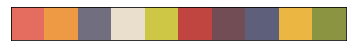

In [101]:


# First, we create a color map for gumballs.
colors = [
    '#e56d60',
    '#ee9944',
    '#716e80',
    '#eadecd',
    '#cec746',
    '#c0443f',
    '#734d56',
    '#5d5f7b',
    '#ecb642',
    '#8a9441',
]
cmap = LinearSegmentedColormap.from_list(name='gumball',
                                         colors=colors,
                                         N=len(colors))

color_rgbas = view_colormap(cmap)

In [102]:
pt = Chem.GetPeriodicTable()
atom_types = [pt.GetElementSymbol(a.GetAtomicNum()) for a in mol.GetAtoms()]

color_dict = {
    'C':1,
    'H':3,
    'N':2,
    'O':5,
    'S':8,
    'P':9
}


color_rgbas = fresnel.color.linear(cmap(np.arange(cmap.N)))
color = np.array([color_rgbas[color_dict[i]] for i in atom_types])


# Fresnel general rules:

- lower fstop tends to make the edges look fuzzy, assuming:
- to achieve the fuzziness, you have to set the `scene.camera.focus_on` to look _before_ or _after_ the centre of mass
- setting it _after_ the centre of mass can lead to cool bokeh-type effect with fuzzy atoms close up, in-focus atoms further away. Molecules look like they're flying through the air. 
- setting it _before_ the centre of mass can just make the whole thing fuzzy as if it's in a cloud
- focal length is basically zoom - can't have it too high or the molecule goes out of frame.
- setting the light color to low values makes it darker basically, which might have some use in composite scenes but otherwise looks bad
- `theta` controls the width of the light source - you can see it by judging the size of the reflected light points. Bigger theta means a wider light source, with softer shadows.

# VDW Spheres

Just add coordinates for the spheres using the `fresnel.geometry.Sphere`


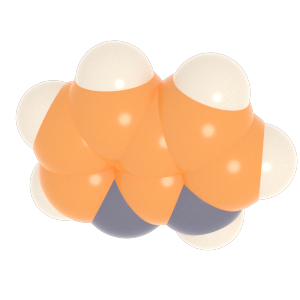

In [6]:
import fresnel

material = fresnel.material.Material(
    primitive_color_mix=1.0,
    roughness=0.2,
    specular=0.8,
)

# We create a fresnel scene and its geometry.
scene = fresnel.Scene()

geometry = fresnel.geometry.Sphere(
    scene,
    position=positions,
    radius=radii,
    color=color,
    material=material,
)



# Configure camera and lighting.
scene.camera = fresnel.camera.Perspective(position=(0, 0, 20),
                                          look_at=(0, 0, 0),
                                          up=(0, 1, 0),
                                          focal_length=0.5,
                                          f_stop=2)

scene.camera.focus_on = (0, 0, 0)
scene.lights = fresnel.light.lightbox()
scene.lights.append(
    fresnel.light.Light(direction=(0.3, -0.3, 1),
                        #color=(0.9, 0.9, 0.9),
                        theta=np.pi/15))

# Execute rendering.
out = fresnel.pathtrace(scene, w=300, h=300, samples=500, light_samples=28)
out

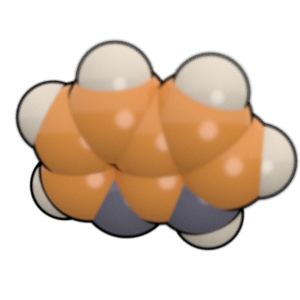

In [7]:
#try with outlines, and a more mellow light setting using fresnel.light.cloudy().
#also focus a bit past the molecule.

material = fresnel.material.Material(
    primitive_color_mix=1.0,
    roughness=0.2,
    specular=0.8,
)

# We create a fresnel scene and its geometry.
scene = fresnel.Scene()

geometry = fresnel.geometry.Sphere(
    scene,
    position=positions,
    radius=radii,
    color=color,
    material=material,
    outline_width = 0.1
)

# Configure camera and lighting.
scene.camera = fresnel.camera.Perspective(position=(0, 0, 20),
                                          look_at=(0, 0, 0),
                                          up=(0, 1, 0),
                                          focal_length=0.5,
                                          f_stop=0.5)

scene.camera.focus_on = (0, 0, -3)
#scene.lights = fresnel.light.lightbox()
scene.lights = fresnel.light.cloudy()

scene.lights.append(
    fresnel.light.Light(direction=(0.3, -0.3, 1),
                        theta=np.pi/10))

# Execute rendering.
out = fresnel.pathtrace(scene, w=300, h=300, samples=500, light_samples=28)
out


# Sticks

Stick / licorice style is achieved with `Cylinder`. Have to iterate over the bonds in the adjacency matrix to generate each cylinder and it's two colours.

Note: all stick representations benefit from a thin outline (0.01). Spheres tend to look cool when they melt into the environment, but sticks pop more with outline.

In [8]:
adjmat = Chem.GetAdjacencyMatrix(mol)
j,k = adjmat.nonzero()

cylinders = list()
cyl_color = list()
for i in range(j.shape[0]):
    at1 = j[i]
    at2 = k[i]
    pt1, pt2 = list(positions[at1]), list(positions[at2])
    cylinders.append([pt1, pt2])
    cyl_color.append([color[at1], color[at2]])

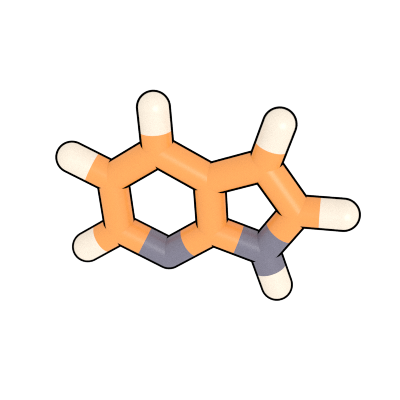

In [9]:
# We create a fresnel scene and its geometry.
scene = fresnel.Scene()

material = fresnel.material.Material(
    primitive_color_mix=1.0,
    roughness=0.3,
    specular=0.8,
    #metal=0.5
)

geometry = fresnel.geometry.Cylinder(
    scene,
    N=len(cylinders), 
    outline_width=0.05,
    material=material
)

geometry.points[:] = cylinders
geometry.radius[:] = [0.4]*len(cylinders)
geometry.color[:] = cyl_color
geometry.material.primitive_color_mix = 1.0

# Configure camera and lighting.
scene.camera = fresnel.camera.Perspective(position=(0, 0, 20),
                                          look_at=(0, 0, 0),
                                          up=(0, 1, 0),
                                          focal_length=0.5,
                                          f_stop=2)

scene.camera.focus_on = (0, 0, 0) #no fuzz
scene.lights = fresnel.light.lightbox()
scene.lights.append(
    fresnel.light.Light(direction=(0.3, -0.3, 1),
                        #color=(0.9, 0.9, 0.9),
                        theta=np.pi/10))

# Execute rendering.
out = fresnel.pathtrace(scene, w=400, h=400, samples=500, light_samples=8)
out

# Combine stick and sphere:
This gives the CPK-style rendering.

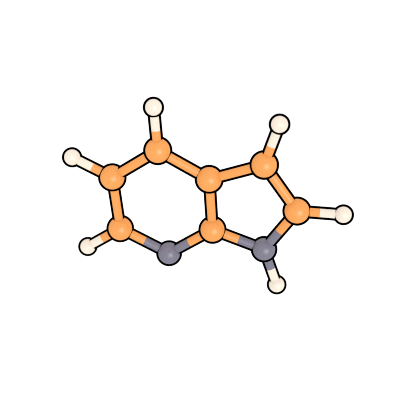

In [131]:
# We create a fresnel scene and its geometry.
scene = fresnel.Scene()

material = fresnel.material.Material(
    primitive_color_mix=1.0,
    roughness=0.3,
    specular=0.8,
    #metal=0.5
)


###First add the cylinders geometry to the scene:

outl = 0.05
stick_geometry = fresnel.geometry.Cylinder(
    scene,
    N=len(cylinders), 
    outline_width=outl,
    material=material
)
stick_geometry.points[:] = cylinders
stick_geometry.radius[:] = [0.15]*len(cylinders) 
stick_geometry.color[:] = cyl_color
stick_geometry.material.primitive_color_mix = 1.0



###Next add the spheres geometry to the scene

sphere_geometry = fresnel.geometry.Sphere(
    scene,
    position=positions,
    radius=radii/5,
    color=color,
    material=material,
    outline_width = outl
)

# Configure camera and lighting.
scene.camera = fresnel.camera.Perspective(position=(0, 0, 20),
                                          look_at=(0, 0, 0),
                                          up=(0, 1, 0),
                                          focal_length=0.5,
                                          f_stop=2)

scene.camera.focus_on = (0, 0, 0) #no fuzz
scene.lights = fresnel.light.lightbox()
scene.lights.append(
    fresnel.light.Light(direction=(0.3, -0.3, 1),
                        #color=(0.9, 0.9, 0.9),
                        theta=np.pi/10))

# Execute rendering.
out = fresnel.pathtrace(scene, w=400, h=400, samples=500, light_samples=8)
out

# Try a whole protein
Principles are exactly the same

In [106]:
#see https://www.cgl.ucsf.edu/chimerax/docs/user/radii.html
radius_lookup = {}
radius_lookup['C']=1.7
radius_lookup['H']=1.0
radius_lookup['N']=1.625
radius_lookup['O']=1.49
radius_lookup['S']=1.782
radius_lookup['P']=1.871

In [107]:
u = mda.Universe('6gj7.pdb')
prot = u.select_atoms("protein")
lig = u.select_atoms("not protein and not resname HOH and not name MG")


prot_atom_types = [i.element for i in prot]

prot_col_idx = [color_dict[i] for i in prot_atom_types]
prot_colors = np.array([color_rgbas[i] for i in prot_col_idx])
prot_radii = [radius_lookup[i] for i in prot_atom_types]

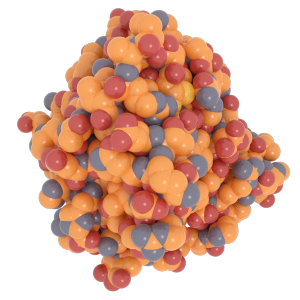

In [108]:
material = fresnel.material.Material(
    primitive_color_mix=1.0,
    roughness=0.2,
    specular=0.8,
)

# We create a fresnel scene and its geometry.
scene = fresnel.Scene()

geometry = fresnel.geometry.Sphere(
    scene,
    position=prot.positions - prot.positions.mean(0),
    radius=prot_radii,
    color=prot_colors,
    material=material,
)

# Configure camera and lighting.
scene.camera = fresnel.camera.Perspective(position=(0, 0, 100),
                                          look_at=(0, 0, 0),
                                          up=(0, 1, 0),
                                          focal_length=0.5,
                                          f_stop=2)

scene.camera.focus_on = (0, 0, 0)
scene.lights = fresnel.light.lightbox()
scene.lights.append(
    fresnel.light.Light(direction=(0.3, -0.3, 1),
                        #color=(0.9, 0.9, 0.9),
                        theta=np.pi/15))

# Execute rendering.
out = fresnel.pathtrace(scene, w=300, h=300, samples=500, light_samples=28)
out

In [109]:
lig_atom_types = [i.element for i in lig]

lig_col_idx = [color_dict[i] for i in lig_atom_types]
lig_colors = np.array([color_rgbas[i] for i in lig_col_idx])
lig_radii = [radius_lookup[i] for i in lig_atom_types]

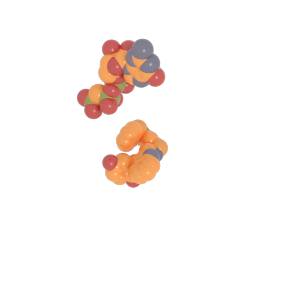

In [110]:
material = fresnel.material.Material(
    primitive_color_mix=1.0,
    roughness=0.2,
    specular=0.8,
)

# We create a fresnel scene and its geometry.
scene = fresnel.Scene()

geometry = fresnel.geometry.Sphere(
    scene,
    position=lig.positions - prot.positions.mean(0),
    radius=lig_radii,
    color=lig_colors,
    material=material,
)

# Configure camera and lighting.
scene.camera = fresnel.camera.Perspective(position=(0, 0, 100),
                                          look_at=(0, 0, 0),
                                          up=(0, 1, 0),
                                          focal_length=0.5,
                                          f_stop=2)

scene.camera.focus_on = (0, 0, 0)
scene.lights = fresnel.light.lightbox()
scene.lights.append(
    fresnel.light.Light(direction=(0.3, -0.3, 1),
                        #color=(0.9, 0.9, 0.9),
                        theta=np.pi/15))

# Execute rendering.
out = fresnel.pathtrace(scene, w=300, h=300, samples=500, light_samples=28)
out

# Try a mesh instead:
it looks a bit funny in that gumball representation.

The mesh here comes from ChimeraX (just write `'save prot.stl'`)

In [24]:
import open3d as o3d

In [27]:
prot.write('prot.pdb')

##
##go into chimerax, load prot.pdb, 
##remove ribbon, show surface, write `save 'prot.stl'`
##

mesh = o3d.io.read_triangle_mesh("prot.stl")
protv = np.array(mesh.vertices)
protf = np.array(mesh.triangles)


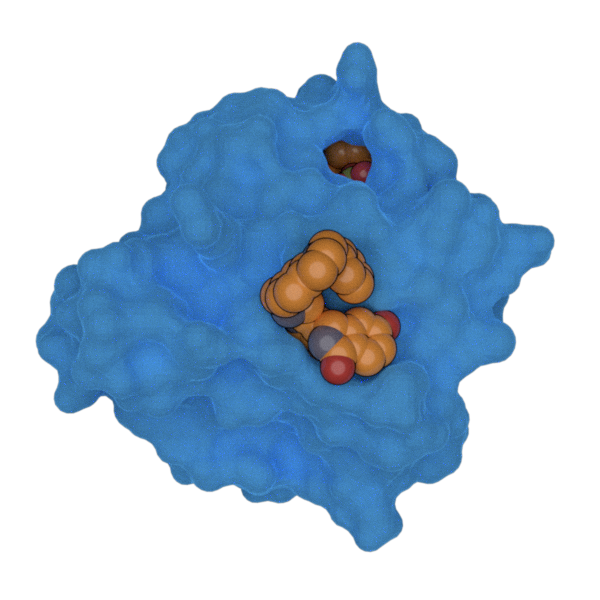

In [62]:
#create a scene:
scene = fresnel.Scene()

#create a geometry in that scene:
#fresnel expects vertices in a particular winding, hence the reshape
prot_geom = fresnel.geometry.Mesh(scene, vertices=protv[protf].reshape(-1,3) - prot.positions.mean(0)) 
prot_geom.material = fresnel.material.Material(roughness=2, 
                                               specular=0.95, 
                                               spec_trans=0.15,
                                              color=fresnel.color.linear(np.array([89, 175, 240])/255))


material = fresnel.material.Material(
    primitive_color_mix=1.0,
    roughness=0.2,
    specular=0.8,
)
lig_geom = fresnel.geometry.Sphere(
    scene,
    position=lig.positions - prot.positions.mean(0),
    radius=lig_radii,
    color=lig_colors,
    material=material,
     outline_width = 0.1
)


scene.camera = fresnel.camera.Orthographic.fit(scene1, view='front', margin=0.25)

# Configure camera and lighting.
scene.camera = fresnel.camera.Perspective(position=(0, 0,-120),
                                          look_at=(0, 0, 0),
                                          up=(0, 1, 0),
                                          focal_length=0.5,
                                          f_stop=25)


scene.lights = fresnel.light.ring()
fresnel.pathtrace(scene, samples=1500, h=600, w=600)
#fresnel.preview(scene)

# Experiment:

Can I get a rep like david goodsell?

[[0.89803922 0.42745098 0.37647059 1.        ]
 [0.93333333 0.6        0.26666667 1.        ]
 [0.39607843 0.5254902  0.78039216 1.        ]
 [0.91764706 0.87058824 0.80392157 1.        ]
 [0.80784314 0.78039216 0.2745098  1.        ]
 [0.75294118 0.26666667 0.24705882 1.        ]
 [0.45098039 0.30196078 0.3372549  1.        ]
 [0.36470588 0.37254902 0.48235294 1.        ]
 [0.9254902  0.71372549 0.25882353 1.        ]
 [0.54117647 0.58039216 0.25490196 1.        ]]


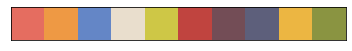

In [114]:
goodsell_dict = {
    'C':2,
    'N':7,
    'O':7,
    'P':7,
    'S':7
}
gdsl_col_idx = [goodsell_dict[i] for i in prot_atom_types]
gdsl_colors = np.array([color_rgbas[i] for i in gdsl_col_idx])



ligcolors = [
    '#e56d60',
    '#ee9944',
    #'#716e80',
    '#6586c7', #replaced with this:
    '#eadecd',
    '#cec746',
    '#c0443f',
    '#734d56',
    '#5d5f7b',
    '#ecb642',
    '#8a9441',
]
ligcmap = LinearSegmentedColormap.from_list(name='lig',
                                         colors=ligcolors,
                                         N=len(ligcolors))

lig_color_rgbas = view_colormap(ligcmap)

lig_col_idx = [color_dict[i] for i in lig_atom_types]
lig_colors = np.array([lig_color_rgbas[i] for i in lig_col_idx])
lig_radii = [radius_lookup[i] for i in lig_atom_types]

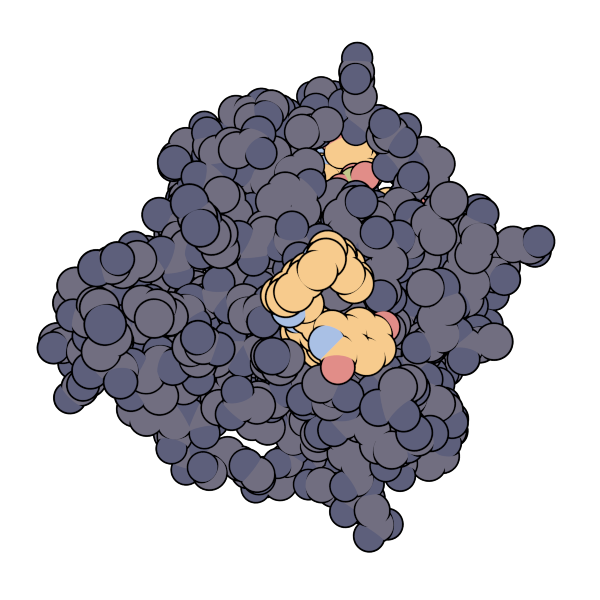

In [127]:
material = fresnel.material.Material(
    primitive_color_mix=1.0,
    roughness=1,
    specular=0,
    solid=0.9
)

# We create a fresnel scene and its geometry.
scene = fresnel.Scene()

geometry = fresnel.geometry.Sphere(
    scene,
    position=prot.positions - prot.positions.mean(0),
    radius=prot_radii,
    color=gdsl_colors,
    material=prot_material,
    outline_width=0.175
)


ligmaterial = fresnel.material.Material(
    primitive_color_mix=1.0,
    roughness=0.2,
    specular=0.8,
    solid=0.9
)

lig_geom = fresnel.geometry.Sphere(
    scene,
    position=lig.positions - prot.positions.mean(0),
    radius=lig_radii,
    color=lig_colors[:,:-1],
    material=ligmaterial,
     outline_width = 0.175,
)

# Configure camera and lighting.
scene.camera = fresnel.camera.Perspective(position=(0, 0, -120),
                                          look_at=(0, 0, 0),
                                          up=(0, 1, 0),
                                          focal_length=0.5,
                                          f_stop=2)

scene.camera.focus_on = (0, 0, 0)
scene.lights = fresnel.light.lightbox()
scene.lights.append(
    fresnel.light.Light(direction=(0.3, -0.3, 1),
                        color=(0.2, 0.2, 0.2),
                        theta=np.pi/15))

# Execute rendering.
out = fresnel.pathtrace(scene, w=600, h=600, samples=500, light_samples=24)
out
#fresnel.preview(scene)